### DSML investigation

You are part of the Suisse Impossible Mission Force, or SIMF for short. You need to uncover a rogue agent that is trying to steal sensitive information.

Your mission, should you choose to accept it, is to find that agent before stealing any classified information. Good luck!

# Assignment part five

More information came in that suggests that the rogue agent is tampering with the sentiment annotation system of the SIMF which analyses news documents and marks their sentiment for intelligence analysis tasks.

This annotation is crucial to identify documents expressing negativity towards Switzerland and its allies.

Each document contains a column which shows which user accessed it. We know that the rogue agent accessed only the documents whose negative sentiment was high, and then changed them to positive or neutral. We will use a huggingface model to identify which records have been tampered with.


[You can find more models on this link](https://huggingface.co/models?sort=trending)


In [1]:
# Install the required libraries (you need to run this cell ONLY if you are running the notebook locally)
# No need to run this cell in colab!
%%capture
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs
!pip install transformers[torch]
!pip install accelerate -U
!pip install openpyxl

!pip install -q transformers
%pip install ipywidgets
%pip install --upgrade transformers huggingface_hub torch



In [2]:
# Import required packages
from transformers import pipeline, DataCollatorWithPadding
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

torch.cuda.is_available()

# Import standard libraries
import pandas as pd
import numpy as np
import math
import bs4 as bs
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Import for text analytics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Import metrics libraries
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. Getting to know our data

In [3]:
df = pd.read_excel('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Assignements/Part%205/data/Reduced_Set_2100.xlsx')

In [4]:
df.head(2)

,company,title,news,evaluation,year,month,day
0,APPLE,Tourists snap up British iPads to smuggle into...,IT'S the digital version of the slow boat to C...,negative,2011,4,17
1,CHEVRON,AFTER SEATTLE; Anarchists get organized.,"For Juliette Beck, it began with the story of ...",negative,2000,4,17


### 2. Re-evaluating with SIMF's Model

We will re-evaluate the sentiment on the `title` column using a sentiment analysis pipeline based on the `finiteautomata/bertweet-base-sentiment-analysis` model. This is a sentiment analysis model trained on ~40k tweets. It classifies a text as `POS` (positive), `NEU` (neutral), or `NEG` (negative) sentiment.

Initialize a sentiment analysis classifier with the pre-trained model mentioned above, making sure to set the correct value for the `task` parameter.

**Note**: Set the `top_k` argument to `None` to retrieve the probabilities for all possible sentiment labels in the output.

_This process may take some time._

In [5]:
sentiment_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis", task="sentiment-analysis", top_k=None)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Apply the sentiment classifier to the `title` column and assign the corresponding sentiment labels to a new column in your dataframe.

Make sure to convert the sentiment labels from the model by replacing them with more descriptive terms like this:
- **NEU**: neutral
- **NEG**: negative
- **POS**: positive

*Hint: Be mindful of the format of the classifier’s output.*

_Beware that applying the model on all of the rows may take some time_

In [6]:
df['new_sentiment'] = df['title'].apply(lambda title: sentiment_model(title))
print(df['new_sentiment'].iloc[0])

[[{'label': 'NEU', 'score': 0.8835569620132446}, {'label': 'NEG', 'score': 0.0922793447971344}, {'label': 'POS', 'score': 0.024163736030459404}]]


In [7]:
def map_sentiment(sentiment_output):
    if isinstance(sentiment_output[0], list):
        sentiment_output = sentiment_output[0]

    best_sentiment = max(sentiment_output, key=lambda x: x['score'])
    label = best_sentiment['label']
    if label == 'NEU':
        return 'neutral'
    elif label == 'NEG':
        return 'negative'
    elif label == 'POS':
        return 'positive'

df['sentiment_label'] = df['new_sentiment'].apply(map_sentiment)
df[['new_sentiment', 'sentiment_label']].head()

,new_sentiment,sentiment_label
0,"[[{'label': 'NEU', 'score': 0.8835569620132446...",neutral
1,"[[{'label': 'NEU', 'score': 0.966677725315094}...",neutral
2,"[[{'label': 'NEG', 'score': 0.8902711272239685...",negative
3,"[[{'label': 'POS', 'score': 0.6151900887489319...",positive
4,"[[{'label': 'NEU', 'score': 0.5660677552223206...",neutral


In [8]:
display(df.head())

,company,title,news,evaluation,year,month,day,new_sentiment,sentiment_label
0,APPLE,Tourists snap up British iPads to smuggle into...,IT'S the digital version of the slow boat to C...,negative,2011,4,17,"[[{'label': 'NEU', 'score': 0.8835569620132446...",neutral
1,CHEVRON,AFTER SEATTLE; Anarchists get organized.,"For Juliette Beck, it began with the story of ...",negative,2000,4,17,"[[{'label': 'NEU', 'score': 0.966677725315094}...",neutral
2,Exxon Mobil,$10bn oil payout voided,SAN FRANCISCO: An appeal court yesterday voide...,negative,2001,11,9,"[[{'label': 'NEG', 'score': 0.8902711272239685...",negative
3,WAL MART STORES,Craft capitalism: Just do it yourself; Web mar...,The declaration from the Handmade Consortium m...,negative,2007,12,15,"[[{'label': 'POS', 'score': 0.6151900887489319...",positive
4,Exxon Mobil,Chevron gas project gets state green light,SYDNEY: Chevron has received final environment...,negative,2007,9,8,"[[{'label': 'NEU', 'score': 0.5660677552223206...",neutral


Now, display the number of unique sentiment evaluations for both the Hugging Face and SIMF models to compare the distribution of labels.

Next, calculate and display the accuracy of the Hugging Face sentiment analysis compared to the SIMF evaluation. Finally, visualize the comparison using a heatmap of the confusion matrix to better understand where the two models align or differ.

'Hugging Face Sentiment Distribution:'

,count
sentiment_label,
neutral,1380
negative,384
positive,336


'SIMF Sentiment Distribution:'

,count
evaluation,
negative,700
neutral,700
positive,700


0.43476190476190474

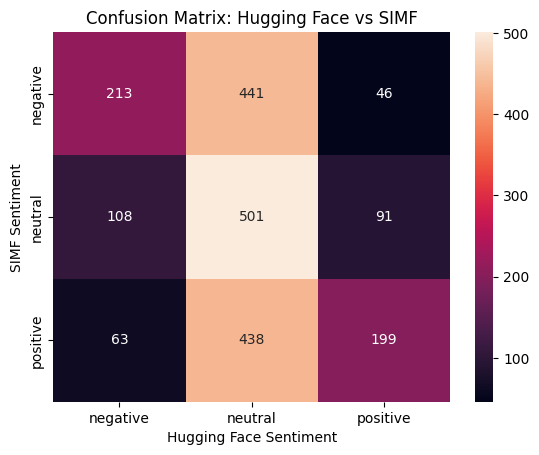

In [9]:
hf_sentiment_distribution = df['sentiment_label'].value_counts()
display("Hugging Face Sentiment Distribution:", hf_sentiment_distribution)
simf_sentiment_distribution = df['evaluation'].value_counts()
display("SIMF Sentiment Distribution:", simf_sentiment_distribution)

accuracy = accuracy_score(df['evaluation'], df['sentiment_label'])
display(accuracy)

conf_matrix = confusion_matrix(df['evaluation'], df['sentiment_label'], labels=['negative', 'neutral', 'positive'])

plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Hugging Face Sentiment')
plt.ylabel('SIMF Sentiment')
plt.title('Confusion Matrix: Hugging Face vs SIMF')
plt.show()

**Q1. Does the SIMF sentiment classifier predicts more samples to be "neutral"  compared to the Hugging Face sentiment classifier?**

In [10]:
hf_neutral_count = hf_sentiment_distribution['neutral']
simf_neutral_count = simf_sentiment_distribution['neutral']
print(simf_neutral_count)
print(hf_neutral_count)

if hf_neutral_count > simf_neutral_count:
    print("Non")
else:
    print("Oui")

700
1380
Non


## 2.1 Entries match both the SIMF model **and** the hugginface model

The SIMF model values are found in the `evaluation` column, while the hugginface model values should be found in the `new_column`, which you added to the table in the previous step.

Display:
*   The rows/records with same sentiment for both models.
*   The number of matching values.
*   The share of matching values of the total number of values.



In [11]:
matching_rows = df[df['evaluation'] == df['sentiment_label']]
display(matching_rows.head())

num_matching = len(matching_rows)
print(num_matching)

total_rows = len(df)
matching_percentage = (num_matching / total_rows) * 100
print(matching_percentage)

,company,title,news,evaluation,year,month,day,new_sentiment,sentiment_label
2,Exxon Mobil,$10bn oil payout voided,SAN FRANCISCO: An appeal court yesterday voide...,negative,2001,11,9,"[[{'label': 'NEG', 'score': 0.8902711272239685...",negative
12,MICROSOFT,"Greenpeace slams Microsoft, Nintendo's 'toxic'...",AMSTERDAM - Microsoft and Nintendo are taking ...,negative,2007,11,29,"[[{'label': 'NEG', 'score': 0.8498765826225281...",negative
13,PEPSICO,PESTICIDE PANIC,NEW DELHI: India's top court has asked local s...,negative,2006,8,6,"[[{'label': 'NEG', 'score': 0.9590968489646912...",negative
14,Exxon Mobil,"High-cost oil projects may be wasted, report says",More than $1tn (£600bn) is being gambled on hi...,negative,2014,5,8,"[[{'label': 'NEG', 'score': 0.9412946701049805...",negative
23,Exxon Mobil,MORE TOXIC SLUDGE FEARED IN WATERWAY,WORKERS BUILDING a park on Newtown Creek hit u...,negative,2005,2,24,"[[{'label': 'NEG', 'score': 0.9714607000350952...",negative


913
43.476190476190474


**Q2. How many entries are identical between the SIMF model evaluation and the Hugging Face model evaluation?**

*Note: Provide your answer as an integer (e.g., 80).*

## 2.2 Entries that do not match both models
Identify all non matching entries.

Create a subset with all the entries that were evaluated differently by the two models.

In [12]:
non_matching_rows = df[df['evaluation'] != df['sentiment_label']]
display(non_matching_rows.head())

num_non_matching = len(non_matching_rows)
print(num_non_matching)

,company,title,news,evaluation,year,month,day,new_sentiment,sentiment_label
0,APPLE,Tourists snap up British iPads to smuggle into...,IT'S the digital version of the slow boat to C...,negative,2011,4,17,"[[{'label': 'NEU', 'score': 0.8835569620132446...",neutral
1,CHEVRON,AFTER SEATTLE; Anarchists get organized.,"For Juliette Beck, it began with the story of ...",negative,2000,4,17,"[[{'label': 'NEU', 'score': 0.966677725315094}...",neutral
3,WAL MART STORES,Craft capitalism: Just do it yourself; Web mar...,The declaration from the Handmade Consortium m...,negative,2007,12,15,"[[{'label': 'POS', 'score': 0.6151900887489319...",positive
4,Exxon Mobil,Chevron gas project gets state green light,SYDNEY: Chevron has received final environment...,negative,2007,9,8,"[[{'label': 'NEU', 'score': 0.5660677552223206...",neutral
5,CHEVRON,RIVALS WILL ACCUSE BP,[…] BP was expected to be hung out to dry by r...,negative,2010,6,15,"[[{'label': 'NEU', 'score': 0.5547481179237366...",neutral


1187


## 2.3 Predicted negative, but evaluated as neutral or positive by the SIMF model

Remember, we are looking at document that were tempered (altered). We suspect that the rogue agent accessed only the documents whose negative sentiment was high, and was then changed to positive or neutral.

Create a subset with only those values, which appear as 'positive' or 'neutral' in the original `evaluation` column, but are marked as having a 'negative' sentiment by the new hugginface model.

**This subset is what we'll call the end of the assignment : "Altered Documents".**

In [13]:
altered_documents = df[(df['evaluation'].isin(['positive', 'neutral'])) & (df['sentiment_label'] == 'negative')]

**Q3. How many entries were changed from a negative evaluation (in the Hugging Face model) to a neutral or positive evaluation (by the SIMF model)?**

*Note: Provide your answer as an integer (e.g., 45).*


In [14]:
num_altered_documents = len(altered_documents)
print(num_altered_documents)

171


# 3. Use the ChangeLog dataframe to identify the usersID's who edited the entries.

Consider the subset you created in the previous step : *the altered documents*.

By combining it with ChangeLog, display only those userIDs, that belong to the people who tried to mask the 'negative' sentiments by assigning these sentences a 'positive' or 'neutral' value.

In other words, match the previous subset with corresponding UserIDs.

In [15]:
ChangeLog = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Assignements/Part%205/data/ChangeLogFix.csv')

In [16]:
ChangeLog['UserID'] = ChangeLog['UserID'].str.strip('[]').astype(int)

In [17]:
suspect_users = pd.merge(altered_documents, ChangeLog, left_on='title', right_on='title', how='inner')

suspect_choices = [535048, 241404, 910222, 515957, 850103]
filtered_suspects = suspect_users[suspect_users['UserID'].isin(suspect_choices)]
unique_suspects = filtered_suspects.drop_duplicates(subset='UserID')
print(unique_suspects[['UserID', 'title']])

   UserID                                              title
0  241404  Letters: Anger simmers over energy bills; Thes...
1  535048  Letters: Anger simmers over energy bills; Thes...
4  850103     So How Contaminated Is the Old Nuclear Plant? 
5  515957     So How Contaminated Is the Old Nuclear Plant? 


**Q4. Which of the following users remain suspects when considering only the documents evaluated as negative by the Hugging Face model but not by the SIMF model?**

*Note: Select among the following answers*


Initialize the `TfidfVectorizer` with unigrams (`ngram_range=(1, 1)`) and set the `stop_words` parameter to `'english'` to exclude common English words from the analysis.


Apply the vectorizer to the corpus of text and convert the resulting document-term matrix into a DataFrame for easy visualization and analysis.


In [18]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
learn = vectorizer.fit_transform(df['news'])
tfidf_df = pd.DataFrame(learn.todense(), columns=vectorizer.get_feature_names_out())

We now want to focus solely on the **"altered documents"**.

To do this, use the previously created list that contains the documents where the Hugging Face model gave a **negative** evaluation, but the SIMF model evaluated them as **neutral** or **positive**.

From this list of documents, extract the corresponding text from the `news` column to obtain a list of articles.

In [19]:
altered_news_texts = altered_documents['news'].tolist()

Now, we will identify the document that stands out the most among the altered documents based on the TF-IDF values.

1. **Filter the TF-IDF DataFrame**: Keep only the entries from the `tfidf_df` that correspond to the tampered documents.
   
2. **Sum TF-IDF Values**: For each tampered document, calculate the sum of the TF-IDF values across all tokens. This gives an overall importance score for each document.

3. **Find the Most Significant Document**: Identify the document with the highest summed TF-IDF value, which stands out the most. Retrieve its index from the original DataFrame `df` and display the details of this document.

In [20]:
altered_indices = altered_documents.index
filtered_tfidf = tfidf_df.loc[altered_indices]

tfidf_sums = filtered_tfidf.sum(axis=1)
most_significant_doc_index = tfidf_sums.idxmax()
print(most_significant_doc_index)

most_significant_doc = df.loc[most_significant_doc_index]
print(most_significant_doc)

1761
company                                             GENERAL ELECTRIC
title              Force of Nature; Environmentalism is no longer...
news               It seems like a hippie entrepreneur's dream co...
evaluation                                                  positive
year                                                            2006
month                                                              8
day                                                               14
new_sentiment      [[{'label': 'NEG', 'score': 0.8986452221870422...
sentiment_label                                             negative
Name: 1761, dtype: object


**Q5. What is the name's company of the most important altered document?**

*Note: The most important altered document means the document with the highest summed TF-IDF value.*

Now, across the altered documents, let's identify the words that stand out the most, meaning those with the highest summed TF-IDF values.

To achieve this, sum the values of each column in the altered TF-IDF dataframe, since each column represents a token. Then, sort these summed values in descending order to easily identify the top 4 words with the highest TF-IDF scores.

Once you have these top 4 words, count in how many *altered documents* each top word appeared.

In [21]:
altered_tfidf_df = tfidf_df.loc[altered_indices]
word_sums = altered_tfidf_df.sum(axis=0)

top_4_words = word_sums.sort_values(ascending=False).head(4)
print(top_4_words)

word_appearances = (altered_tfidf_df[top_4_words.index] > 0).sum()
print(word_appearances)

carbon     5.759377
said       5.589130
energy     5.010363
climate    4.983437
dtype: float64
carbon     55
said       97
energy     70
climate    49
dtype: int64


**Q6. What is the token with the highest summed TF-IDF value?**

*Note: Select among the following answers*

In [22]:
top_token = word_sums.idxmax()
top_token_value = word_sums.max()
print(top_token)

carbon


**Q7. In how many altered documents do the third most frequent word appeared ?**

*Note: Provide your answer as an integer (e.g., 45).*

In [23]:
sorted_tokens = word_sums.sort_values(ascending=False)
third_most_frequent_token = sorted_tokens.index[2]
num_documents_with_third_token = (altered_tfidf_df[third_most_frequent_token] > 0).sum()
print(num_documents_with_third_token)

70


## Your investigation is progressing effectively, and the list of suspects is narrowing down.

**Don't forget to answer the quiz and submit your code on Moodle before the end of the deadline.**